# eBay Price vs. AvgPrice Analysis
This notebook explores the relationship between **Price** and **AvgPrice** on eBay using machine learning models. The workflow includes data preprocessing, exploratory analysis, model training, and evaluation.


## Data Preparation & Model Training (Price vs. AvgPrice)
This section predicts whether **Price ≥ AvgPrice** for sold items.

### **1. Data Preparation**
- Loads dataset and filters **sold items (`QuantitySold == 1`)**.
- Creates a **binary target variable** (`1` if `Price >= AvgPrice`, else `0`).
- Handles **missing values** (median for numeric, mode for categorical).
- Applies **StandardScaler** and splits data (80% train, 20% validation).

### **2. Model Training**
- **Random Forest (GridSearchCV tuning)**: Optimizes hyperparameters using **5-fold cross-validation**.
- **Logistic Regression (Regularized, class balancing)**: Prevents overfitting with `C=0.1`.

### **3. Performance Evaluation**
- Computes **accuracy, confusion matrix, and classification report** for validation & test sets.


In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Load the full datasets
file_path = 'raw.tar.gz'
extracted_path = '/mnt/data/raw_data/'

import tarfile
import os
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path=extracted_path)

raw_dir = os.path.join(extracted_path, 'raw')
training_set = pd.read_csv(os.path.join(raw_dir, 'TrainingSet.csv'))
test_set = pd.read_csv(os.path.join(raw_dir, 'TestSet.csv'))

# Target 3: Predict if Price is greater than or equal to AvgPrice
train_sub_3 = training_set[training_set['QuantitySold'] == 1]  # Only sales
test_sub_3 = test_set[test_set['QuantitySold'] == 1]  # Only sales

# Create binary target: 1 if Price >= AvgPrice, else 0
y_train_sub_3 = (train_sub_3['Price'] >= train_sub_3['AvgPrice']).astype(int)
y_test_sub_3 = (test_sub_3['Price'] >= test_sub_3['AvgPrice']).astype(int)

# Features for Target 3
features_sub_3 = ['Price', 'AvgPrice', 'SellerClosePercent', 'StartingBid', 'PricePercent', 'StartingBidPercent']

# Using only relevant features for training the models
X_train_sub_3 = train_sub_3[features_sub_3]
X_test_sub_3 = test_sub_3[features_sub_3]

# Split the data first to avoid leakage
X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_train_sub_3, y_train_sub_3, test_size=0.2, random_state=42)

# Check for missing values and handle them (filling numeric columns with median, categorical columns with mode)
numeric_cols = X_train_3.select_dtypes(include=[np.number]).columns
categorical_cols = X_train_3.select_dtypes(exclude=[np.number]).columns

# Fill missing values for numeric columns with median (done before scaling)
X_train_3[numeric_cols] = X_train_3[numeric_cols].fillna(X_train_3[numeric_cols].median())
X_val_3[numeric_cols] = X_val_3[numeric_cols].fillna(X_val_3[numeric_cols].median())
X_test_sub_3[numeric_cols] = X_test_sub_3[numeric_cols].fillna(X_test_sub_3[numeric_cols].median())

# Handle missing values for categorical columns with mode using apply()
X_train_3[categorical_cols] = X_train_3[categorical_cols].apply(lambda col: col.fillna(col.mode().iloc[0]) if not col.mode().empty else col)
X_val_3[categorical_cols] = X_val_3[categorical_cols].apply(lambda col: col.fillna(col.mode().iloc[0]) if not col.mode().empty else col)
X_test_sub_3[categorical_cols] = X_test_sub_3[categorical_cols].apply(lambda col: col.fillna(col.mode().iloc[0]) if not col.mode().empty else col)

# Feature scaling
scaler = StandardScaler()
X_train_3_scaled = scaler.fit_transform(X_train_3)
X_val_3_scaled = scaler.transform(X_val_3)
X_test_sub_3_scaled = scaler.transform(X_test_sub_3)

# Model 1: RandomForestClassifier with Hyperparameter Tuning and Cross-Validation
rf_classifier_3 = RandomForestClassifier(random_state=42, class_weight='balanced')

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees to grow
    'max_depth': [5, 10, 15],  # Limit depth further to prevent overfitting
    'min_samples_split': [5, 10],  # Require more samples to split nodes
    'min_samples_leaf': [5, 10],  # Require more samples in each leaf
    'max_features': ['sqrt', 'log2']  # Use 'sqrt' or 'log2' for feature selection at each split
}

# GridSearchCV to tune Random Forest
grid_search_rf = GridSearchCV(estimator=rf_classifier_3, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_3_scaled, y_train_3)

# Best parameters from GridSearchCV
print("Best parameters for RandomForestClassifier:", grid_search_rf.best_params_)

# Get the best Random Forest model
best_rf_model_3 = grid_search_rf.best_estimator_

# Evaluate using cross-validation on the training set
cv_scores_rf_3 = cross_val_score(best_rf_model_3, X_train_3_scaled, y_train_3, cv=5, scoring='accuracy')
print(f"Random Forest - Mean Accuracy (CV): {cv_scores_rf_3.mean():.4f}, Std Dev (CV): {cv_scores_rf_3.std():.4f}")

# Predictions on the validation set
y_pred_val_rf_3 = best_rf_model_3.predict(X_val_3_scaled)
accuracy_val_rf_3 = accuracy_score(y_val_3, y_pred_val_rf_3)
print(f"Random Forest - Validation Accuracy: {accuracy_val_rf_3:.4f}")

# Evaluate on the test set
y_pred_test_rf_3 = best_rf_model_3.predict(X_test_sub_3_scaled)
accuracy_test_rf_3 = accuracy_score(y_test_sub_3, y_pred_test_rf_3)
print(f"Random Forest - Test Accuracy: {accuracy_test_rf_3:.4f}")

# Model 2: Logistic Regression with Regularization (to prevent overfitting)
lr_classifier_3 = LogisticRegression(random_state=42, class_weight='balanced', C=0.1, solver='liblinear')  # Regularization with C

# Fit Logistic Regression on training data
lr_classifier_3.fit(X_train_3_scaled, y_train_3)

# Predictions on the validation set for Logistic Regression
y_pred_val_lr_3 = lr_classifier_3.predict(X_val_3_scaled)
accuracy_val_lr_3 = accuracy_score(y_val_3, y_pred_val_lr_3)
print(f"Logistic Regression - Validation Accuracy: {accuracy_val_lr_3:.4f}")

# Evaluate on the test set for Logistic Regression
y_pred_test_lr_3 = lr_classifier_3.predict(X_test_sub_3_scaled)
accuracy_test_lr_3 = accuracy_score(y_test_sub_3, y_pred_test_lr_3)
print(f"Logistic Regression - Test Accuracy: {accuracy_test_lr_3:.4f}")

# Confusion Matrix and Classification Report for Random Forest
print("\nConfusion Matrix for Random Forest:")
print(confusion_matrix(y_test_sub_3, y_pred_test_rf_3))

print("\nClassification Report for Random Forest:")
print(classification_report(y_test_sub_3, y_pred_test_rf_3))

# Confusion Matrix and Classification Report for Logistic Regression
print("\nConfusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test_sub_3, y_pred_test_lr_3))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test_sub_3, y_pred_test_lr_3))



<ipython-input-11-9a3f02cddf71>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_sub_3[numeric_cols] = X_test_sub_3[numeric_cols].fillna(X_test_sub_3[numeric_cols].median())


Best parameters for RandomForestClassifier: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50}
Random Forest - Mean Accuracy (CV): 1.0000, Std Dev (CV): 0.0000
Random Forest - Validation Accuracy: 1.0000
Random Forest - Test Accuracy: 1.0000
Logistic Regression - Validation Accuracy: 0.9767
Logistic Regression - Test Accuracy: 0.9767

Confusion Matrix for Random Forest:
[[6700    0]
 [   0 2699]]

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6700
           1       1.00      1.00      1.00      2699

    accuracy                           1.00      9399
   macro avg       1.00      1.00      1.00      9399
weighted avg       1.00      1.00      1.00      9399


Confusion Matrix for Logistic Regression:
[[6484  216]
 [   3 2696]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

 

## ROC Curve & AUC Evaluation  
Evaluates **Random Forest** and **Logistic Regression** using **ROC Curve** and **AUC Score**.  

### **Steps:**  
- Computes **True Positive Rate (TPR)** vs. **False Positive Rate (FPR)**.  
- Calculates **AUC** (higher AUC = better model).  
- Plots **ROC Curve**:
  - **Blue** → Random Forest  
  - **Green** → Logistic Regression  
  - **Gray Dashed Line** → Random baseline  


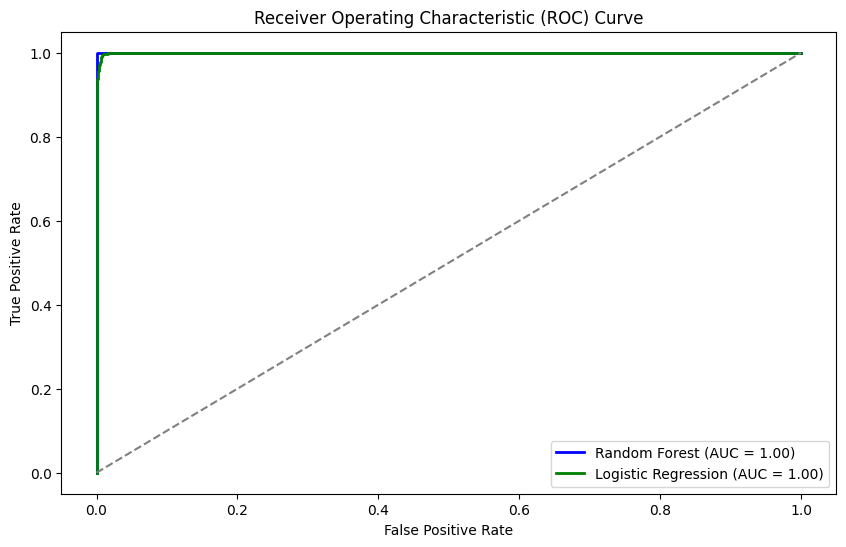

In [ ]:
# ROC Curve and AUC for both models
fpr_rf_3, tpr_rf_3, _ = roc_curve(y_test_sub_3, best_rf_model_3.predict_proba(X_test_sub_3_scaled)[:, 1])
roc_auc_rf_3 = auc(fpr_rf_3, tpr_rf_3)

fpr_lr_3, tpr_lr_3, _ = roc_curve(y_test_sub_3, lr_classifier_3.predict_proba(X_test_sub_3_scaled)[:, 1])
roc_auc_lr_3 = auc(fpr_lr_3, tpr_lr_3)

# Plot ROC Curve for both models
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf_3, tpr_rf_3, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf_3:.2f})')
plt.plot(fpr_lr_3, tpr_lr_3, color='green', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr_3:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()